In [26]:
import numpy as np
import pandas as pd

import cv2
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K


from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

# gráfico
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
LOCAL_ROOT  = 'D:/CelebA_Spoof_32k'
PATH_TEST = LOCAL_ROOT +  '/test'

BATCH_SIZE = 64
IMG_SHAPE = (224, 224, 3)
RANDOM_STATE = 42

In [13]:
path_MobileNetV2 = 'D:/models/CelebA_Spoof_32k_MobileNetV2_50.h5'
path_DenseNet121 = 'D:/models/CelebA_Spoof_32k_DenseNet121_30.h5'
path_Vgg16 = 'D:/models/CelebA_Spoof_32k_VGG16.h5'
path_Vgg19 = 'D:/models/CelebA_Spoof_32k_VGG19.h5'
path_cnn = 'D:/models/CelebA_Spoof_32k_cnn.h5'

In [4]:
test_datagen = ImageDataGenerator(rescale = 1.0/255)

In [5]:
test_generator = test_datagen.flow_from_directory(PATH_TEST,
                                                   target_size=IMG_SHAPE[:-1],
                                                   shuffle=False,
                                                   class_mode='binary',
                                                   batch_size=BATCH_SIZE)

Found 7000 images belonging to 2 classes.


In [6]:
model_MobileNetV2 = models.load_model(path_MobileNetV2)

### DenseNet121

In [7]:
densenet = DenseNet121(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [8]:
model_DenseNet121 = tf.keras.models.Sequential([densenet,
                                    GlobalAveragePooling2D(),
                                    Dense(512, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.3),
                                    Dense(2, activation='sigmoid')
                                    ])

In [9]:
model_DenseNet121.load_weights(path_DenseNet121)

### VGG16

In [10]:
vgg16 = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [11]:
model_vgg16 = tf.keras.models.Sequential([vgg16,
                                    GlobalAveragePooling2D(),
                                    Dense(512, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.3),
                                    Dense(2, activation='sigmoid')
                                    ])

In [14]:
model_vgg16.load_weights(path_Vgg16)

### VGG19

In [15]:
vgg19 = VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [18]:
model_vgg19 = tf.keras.models.Sequential(name='tcc_vgg19')
model_vgg19.add(vgg19)
model_vgg19.add(GlobalAveragePooling2D())
model_vgg19.add(BatchNormalization())
model_vgg19.add(Flatten())
model_vgg19.add(Dense(128, activation='relu'))
model_vgg19.add(Dropout(0.5))
model_vgg19.add(Dense(2, activation='softmax'))

In [20]:
model_vgg19.load_weights(path_Vgg19)

### CNN

In [27]:
def build(width, height, depth, classes):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential(name='tcc_cnn')
    inputShape = (height, width, depth)
    chanDim = -1

    # if we are using "channels first", update the input shape
    # and channels dimension
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

    # first CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(16, (3, 3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

In [28]:
model_cnn = build(width=IMG_SHAPE[0], height=IMG_SHAPE[1], depth=IMG_SHAPE[2], classes=2)

In [29]:
model_cnn.load_weights(path_cnn)

In [30]:
models = [model_MobileNetV2, model_DenseNet121, model_vgg16,  model_vgg19, model_cnn]
names = ['MobileNetV2', 'DenseNet121', 'vgg16', 'vgg19', 'CNN']

In [31]:
def evaluate(models, generator, names):
    results = pd.DataFrame(columns=['accuracy', 'f1-score', 'precision'])
    
    for model, name in zip(models, names):
        print('Avaliando: {}'.format(name))
        pred = model.predict(generator, verbose=1)

        y_test = generator.classes
        y_pred = pred.argmax(axis=1)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)

        results.loc[name, :] = [accuracy, f1, precision]
    
    return results

In [81]:
results = evaluate(models, test_generator, names)

Avaliando: MobileNetV2
110/110 [==============================] - 15s 134ms/step
Avaliando: DenseNet121
110/110 [==============================] - 23s 211ms/step
Avaliando: vgg16
110/110 [==============================] - 39s 350ms/step
Avaliando: vgg19
110/110 [==============================] - 45s 411ms/step
Avaliando: CNN
110/110 [==============================] - 13s 118ms/step


In [82]:
results

,accuracy,f1-score,precision
MobileNetV2,0.921429,0.915876,0.985517
DenseNet121,0.906429,0.898308,0.983679
vgg16,0.866571,0.849694,0.972734
vgg19,0.882857,0.871473,0.965278
CNN,0.874286,0.861505,0.959005


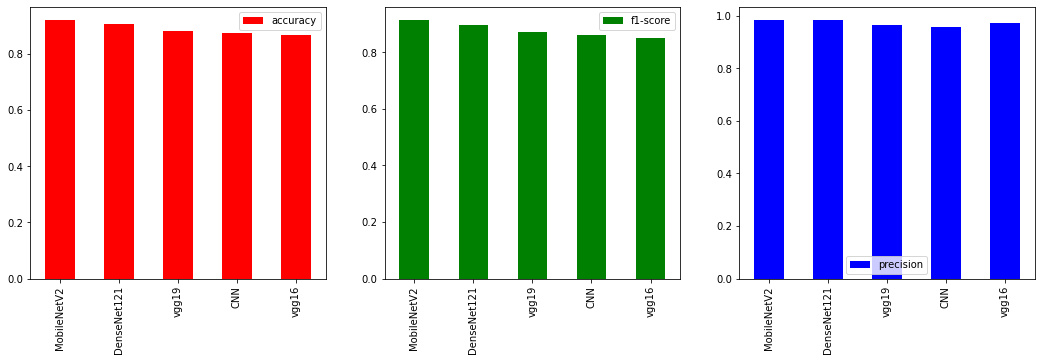

In [89]:
fig, ax = plt.subplots(1,3, figsize=(18,5))

results.sort_values('accuracy', ascending=False).plot.bar(y='accuracy', color='r', ax=ax[0])
results.sort_values('f1-score', ascending=False).plot.bar(y='f1-score', color='g', ax=ax[1])
results.sort_values('accuracy', ascending=False).plot.bar(y='precision', color='b', ax=ax[2])

### Conclusão

O melhor modelo foi o **MobileNetV2** com:
    * Accuracy: 92.14%
    * F1 score: 91.59%
    * precision score: 98.55%
